# QUORA

This notebook is a copy of the IMDB notebook, which is used in the fast.ai course v3. Thx Jeremy Howard 
I used this notebook for  competition on Kaggle
https://www.kaggle.com/c/quora-insincere-questions-classification

In [66]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

In [3]:
pwd

'/home/martijn/kaggle'

In [4]:
path = Path('../kaggle/data/')


## Preparing the data

Take a look at the data

In [5]:
path.ls()

[PosixPath('../kaggle/data/embeddings'),
 PosixPath('../kaggle/data/models'),
 PosixPath('../kaggle/data/train.csv.zip'),
 PosixPath('../kaggle/data/sample_submission.csv'),
 PosixPath('../kaggle/data/sample_submission.csv.zip'),
 PosixPath('../kaggle/data/test.csv.zip'),
 PosixPath('../kaggle/data/test.csv'),
 PosixPath('../kaggle/data/tmp'),
 PosixPath('../kaggle/data/tmp_lm'),
 PosixPath('../kaggle/data/tmp_clas_n_wt103'),
 PosixPath('../kaggle/data/train.csv'),
 PosixPath('../kaggle/data/tmp_lm_q'),
 PosixPath('../kaggle/data/embeddings.zip'),
 PosixPath('../kaggle/data/tmp_clas')]

In [6]:
df = pd.read_csv(path/'train.csv')
df[df['target']==1].head()

,qid,question_text,target
22,0000e91571b60c2fb487,Has the United States become the largest dicta...,1
30,00013ceca3f624b09f42,Which babies are more sweeter to their parents...,1
110,0004a7fcb2bf73076489,If blacks support school choice and mandatory ...,1
114,00052793eaa287aff1e1,I am gay boy and I love my cousin (boy). He is...,1
115,000537213b01fd77b58a,Which races have the smallest penis?,1


It contains one line per question, with the target ('0' or '1'). 

In [7]:
df_y1 = df[df['target']==1]['question_text']

In [8]:
df_y0 = df[df['target']==0].head(100)

In [9]:
df_y1.head(10)

22     Has the United States become the largest dicta...
30     Which babies are more sweeter to their parents...
110    If blacks support school choice and mandatory ...
114    I am gay boy and I love my cousin (boy). He is...
115                 Which races have the smallest penis?
119                    Why do females find penises ugly?
127    How do I marry an American woman for a Green C...
144    Why do Europeans say they're the superior race...
156    Did Julius Caesar bring a tyrannosaurus rex on...
167    In what manner has Republican backing of 'stat...
Name: question_text, dtype: object

## Language model

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipeia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the questions lefts by people on QUORA isn't the same as the English of wikipedia, we'll need to adjust a little bit the parameters of our model. Plus there might be some words extremely common in that dataset that were barely present in wikipedia, and therefore might no be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

### With the data block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the variaous arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [10]:
data_lm = (TextList.from_csv(path, 'train.csv', col='question_text')
                .random_split_by_pct(0.1)           
           #We randomly split and keep 10% (10,000 questions) for validation
                .label_for_lm()   
            #We want to do a language model so we label accordingly
                .databunch()
                )
data_lm.save('tmp_lm_q')

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [69]:
data_lm = TextLMDataBunch.load(path, 'tmp_lm_q', bs=35)

In [72]:
data_lm.show_batch()

idx,text
0,xxfld 1 what is the best way to make a cutting board ? xxfld 1 do people lose contact with old friends from college or school permanently ? xxfld 1 how dies 2 timothy xxunk apply to the book of leviticus ? xxfld 1 can a 2 amp charger be used to charge a 6 volt battery ? xxfld 1 what are some realistic career options for a college math teacher who
1,during early pregnancy ? xxfld 1 what is market socialism ? xxfld 1 how can i get into my facebook messenger ? xxfld 1 how does it feel to have a dick in your asshole and in your vagina simultaneously ? xxfld 1 what is a blue - collar personality ? xxfld 1 what are the disadvantages of welding over riveting ? xxfld 1 is alexander xxunk handsome ? xxfld 1 who
2,"them , is it a crush ? xxfld 1 some people are very fast at accomplishing things . how do they do that ? it 's like magic to me . xxfld 1 what does it mean when the idea of not seeing someone again makes your heart ache ? xxfld 1 what should be the learning path for data science ? xxfld 1 if we complete be in it then we"
3,? xxfld 1 why should i believe in socialism over capitalism ? xxfld 1 is there a group where you can go and just listen to music ? xxfld 1 how much is the average monthly cost of living in malta for a single person ? xxfld 1 what type of beer was john travolta drinking in carrie ? xxfld 1 how should straight writers write believable non - binary characters ?
4,magnesium citrate ? xxfld 1 how can i properly uninstall an over the range microwave ? xxfld 1 did you know that iranians who do not live in tehran ( iranian capital ) do not have the right to act in iranian films ، and they are extremely angry about this ? xxfld 1 what is field weld or site weld ? xxfld 1 what behavioural characteristics does cats display so as
5,it 's so pathetic ? xxfld 1 why wo n't republicans acknowledge all the genders ? xxfld 1 is too much religion killing india ? xxfld 1 is it possible to crack xxup ssc xxup cgl in 2 months ? xxfld 1 how can we register on free xxup mooc test from xxup nptel ? xxfld 1 what will be the best place in sydney for surgical weight loss ? xxfld 1
6,mean that he suddenly signed with 3 xxx ? xxfld 1 how do you stay productive the whole day ? xxfld 1 is breaking mangalsutra a bad omen ? i broke mine today and i am very worried . xxfld 1 how can we prevent the contagion of xxunk during flu season ? xxfld 1 why did the boeing company decided to move its headquarters from seattle to chicago ? xxfld 1
7,her as xxunk and cheat n lied to her ? xxfld 1 is investing in cryptocurrencies the only way to make easy money ? xxfld 1 what is the pneumatic tube system ? xxfld 1 how can i watch spanish tv series with english subtitles ? xxfld 1 how do you make things right with a person you have disappointed many times ? xxfld 1 how can i see if my name
8,"the best used car deal in kenya ? xxfld 1 what is better for computer science engineer if they have no better knowledge about programming ? xxfld 1 why do chinese eat donkeys alive ? xxfld 1 is pakistan heading towards a debt crisis in 2018 ? xxfld 1 can a judge be impartial if he is mormon ? xxfld 1 what does proxemics study ? xxfld 1 in europe , how"
9,of my brother doing normal activities on my parents property ? xxfld 1 was the military industrial complex behind stifling henry wallace and muting his importance in u.s . history ? xxfld 1 how is history introduced in present scenario fantasy novels ? xxfld 1 is there a conservative equivalent to quora ? xxfld 1 what things can make you better and smarter even if you do n't have a job ?


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in './fastai/models/' (or elsewhere if you specified different paths in your config file).

In [6]:
learn_lm = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.3)

In [16]:

learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


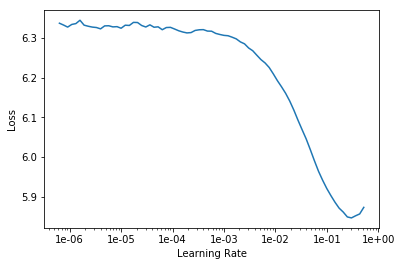

In [17]:
learn_lm.recorder.plot(skip_end=15)

In [18]:
learn_lm.fit_one_cycle(1, 5e-3, moms=(0.8,0.7))

Total time: 28:24
epoch  train_loss  valid_loss  accuracy
1      4.049920    3.894225    0.362843  (28:24)



In [19]:
learn_lm.save('fit_head')

In [7]:
learn_lm.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [8]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(2, slice(1e-3,1e-2), moms=(0.8,0.7))

Total time: 1:04:06
epoch  train_loss  valid_loss  accuracy
1      3.738632    3.647199    0.388309  (31:59)
2      3.531301    3.498232    0.402309  (32:07)



In [9]:
learn_lm.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [10]:
learn_lm.load('fine_tuned');

In [11]:
learn_lm.predict('What are some words', 20, temperature=1.1, min_p=0.001)

Total time: 00:00



'What are some words in first time ? xxfld 1 million of the most of the two " i get you have lived as'

In [12]:
doc(learn_lm.predict)

In [13]:
learn_lm.predict('What is the most amazing', 10, temperature=1.1, min_p=0.001)

Total time: 00:00



'What is the most amazing knowledge for the united states that would you do you'

We have to save the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [ ]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))

In [14]:
learn_lm.save('fine_tuned_e3')

In [15]:
learn_lm.save_encoder('fine_tuned_enc_wt103')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [16]:
data_clas = (TextList.from_csv(path, 'train.csv', col='question_text', vocab=data_lm.vocab)
                .random_split_by_pct(0.1) 
                .label_from_df(cols='target')
                .databunch()
              )            

In [17]:
data_clas.save('tmp_clas_wt103')

In [63]:
data_clas = TextClasDataBunch.load(path, 'tmp_clas_wt103', bs=35)
data_clas.show_batch(10)

text,label
xxfld 1 what is [ math ] \ frac { \ xxunk } } \ tan ( \ tan ( { \ boxed { \ xxunk } \ sum _ { \ xxunk { \ infty } \ xxunk } \ sum _ { \ xxunk { \ infty },1
"xxfld 1 i am a man who is absolutely uncomfortable with women who can overpower me , control me , dominate me , screw me or kick my ass in any way or pose any sort of threat to me . am i unique in feeling this way ? are",0
"xxfld 1 last night i had clear visuals with my eyes closed of perfect geometric things with vibrant colors and patterns . i saw a linear 3d fly and i could zoom in and out her body , like a wire sculpture . does this have to do with science",0
"xxfld 1 why do you have comments disabled on the white privilege question you answered that has had so many views and upvotes ? i completely disagree with you and every comment i read , but i ’m not allowed to say in your thread . do n’t you think",1
"xxfld 1 baking is my favorite thing to do ; especially brownies . but all of a sudden , my family is trying to get in it , even though i explained to them in detail , how i like having things that only i can do . am i",0
xxfld 1 can a guy still be shy around a girl even if he walks and carries himself confidently ? people i have opened up to tell me the guy who stares at me when he thinks i 'm not looking is shy but he carries himself confidently even when,0
"xxfld 1 i 'm very weak at math , i ca nt even do 10th grade math so xxup cat and xxup gmat are impossible for me to crack . how do i get into a top b - school or management college without xxup cat or xxup gmat ?",0
"xxfld 1 why do women claim it was they who secured freedoms , if they do n't acknowledge that they did n't secure them centuries ago ? and why , if they claim men were oppressing them , why do n’t they acknowledge that men stopped oppressing them ?",1
"xxfld 1 if people think you are monster , but you are full of love of life and these people are life so you are full of love for these people but you have tourette 's syndrome , how could you possibly go about expressing this without triggers ?",0
"xxfld 1 why does david deutsch say all 3 of matter , energy , and evidence are needed for a stream of explanatory knowledge ( chapter 3 of the beginning of infinity ) ? why does n't the existence of one imply the existence of the others ?",0


In [83]:
data_clas.train_ds.c, data_clas.valid_ds.c

(2, 2)

We can then create a model to classify those reviews and load the encoder we saved before.

In [22]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

In [23]:
learn_clas = text_classifier_learner(data_clas, drop_mult=0.5, metrics=[accuracy, fbeta]) #the metrics doesn't work

In [36]:
learn_clas.load_encoder('fine_tuned_enc_wt103')
learn_clas.freeze()

In [25]:
learn_clas.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


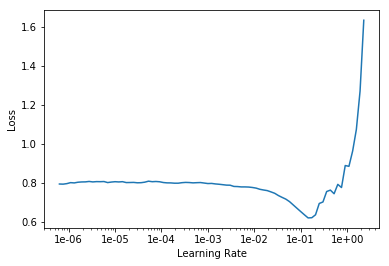

In [26]:
learn_clas.recorder.plot()

In [27]:
learn_clas.freeze_to(-2)
learn_clas.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

Total time: 22:07
epoch  train_loss  valid_loss  accuracy
1      0.158572    0.169488    0.945564  (22:07)



In [ ]:
learn_clas.save('first_wt103')

In [37]:
learn_clas.freeze_to(-3)
learn_clas.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))


Total time: 1:43:11
epoch  train_loss  valid_loss  accuracy
1      0.124179    0.114981    0.956926  (34:16)
2      0.132324    0.119440    0.956895  (32:10)
3      0.126124    0.113798    0.957661  (36:44)



In [38]:
learn_clas.save('second_wt103_09576')

In [84]:
q1 = ' My voice range is A2-C5. My chest voice goes up to F4. Included sample in my higher chest range. What is my voice type?'
q2 = ' My boy friend and I have very different backgrounds (economically, socially and culturally). Sometimes I feel I deserve better. What should I do?'
q3 = 'When is it appropriate to use parametric survival analysis over non-parametric analysis?'


q4 = 'Has the United States become the largest dictatorship in the world?' #(from trainset value 1)
q5 = "If blacks support school choice and mandatory sentencing for criminals why don't they vote Republican?" #(from trainset value 1)
q6 = "why do you have comments disabled on the white privilege question you answered that has had so many views and upvotes ? i completely disagree with you and every comment i read , but i ’m not allowed to say in your thread . do n’t you think" 
q7 = "Can Russia learn from Singapore's effort of eliminating corruption given younger Russian voters call for more anti-corruption, and that both are dictator states?"

q_list = [q1,q2,q3,q4,q5, q6, q7]


In [74]:
learn_clas = learn_clas.load('second_wt103_09576')

In [75]:
learn_clas = learn_clas.load('first_wt103')

predict target 0 questions from trainset

In [76]:
learn_clas.predict(q1)


(0, tensor(0), tensor([0.9920, 0.0080]))

In [77]:
learn_clas.predict(q2)


(0, tensor(0), tensor([0.9877, 0.0123]))

In [78]:
learn_clas.predict(q3)


(0, tensor(0), tensor([0.8945, 0.1055]))

predict target 1 questions from trainset

In [79]:
learn_clas.predict(q5)

(0, tensor(0), tensor([0.8346, 0.1654]))

In [80]:
learn_clas.predict(q6)


(0, tensor(0), tensor([0.8897, 0.1103]))

In [81]:
learn_clas.predict(q7)


(0, tensor(0), tensor([0.9522, 0.0478]))

In [62]:
i = 0
for q in q_list:
    i = i +1
    print (i)
    print("predict {}: ".format(i))
    print(learn_clas.predict(q)[0]) #prints dissappear

0


In [ ]:
learn_clas.unfreeze()
learn_clas.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

In [ ]:
learn_clas.save('second')

In [ ]:
learn_clas.load('second');

In [ ]:
learn_clas.predict(q2, 100, temperature=1.1, min_p=0.001)

In [ ]:
learn_clas.unfreeze()
learn_clas.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

In [ ]:
learn_clas.save('third')

In [ ]:
learn_clas.load('third');

In [ ]:
learn_clas.predict(q3, 100, temperature=1.1, min_p=0.001)

In [ ]:
learn_clas.unfreeze()
learn_clas.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

In [ ]:
learn_clas.predict("I really loved that movie, it was awesome!")